<a href="https://colab.research.google.com/github/MilicaMedic/TPQ_final/blob/main/Deep%20Reinforcement%20Learning%20for%20Multiple%20Cryptocurrency%20Trading%20Using%20Ensemble%20Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for the Multiple Cryptocurrency Trading Using an Ensemble Strategy



# Abstract

The emergence of cryptocurrencies has disrupted traditional financial systems by opening various new investment opportunities. The objective of this project is to implement an automated solution for trading multiple cryptocurrencies by using the Ensembled trading strategy that consist of the following Deep Reinforcement Learning (DRL) agents: Proximal Policy Optimization (PPO), Advantage Actor-Critic (A2C), and Deep Deterministic Policy Gradient (DDPG). The Ensembled strategy combines the best features of the three algorithms, aiming to create a robust solution for adjusting to different market conditions, with the goal to maximize the profits (returns).
The project trains, and trades, on the same dataset, all three agents, the Ensemble strategy, and the min-variance as baseline, and gives a performance comparison of all strategies.

All three agents in an Ensemble stragegy are trained at the same time, quarterly (3-month period), and after each time the best agent is selected based on their Sharpe ratio and used for trading in the next quarter.

For this project the FinRL, an open source framework for financial reinforcement learning, is used.
This work includes 5 crypto tokens that have adequate liquidity, market capitalisation and, also, to how long the coin is listed (how long the data exists, so that it went through a couple of bull/bear cycles).

The cryptocurrency market is challenging due to its high volatility, and unpredictability, offering at the same time opportunities for the significant profits.

# Introduction

In the last decade Reinforcement Leaning (RL) has demonstrated promising results in the finance field. RL enables an agent to learn optimal trading policies through continuous interaction with its environment (e.g. finance market data), allowing for dynamic and efficient decision-making. In this context, the agent uses algorithms to learn the optimal policy without prior knowledge of the state transition probabilities or reward functions, relying instead on observed experiences. RL can be applied as follows:

* Agent: The decision-making algorithm that executes trades.
* Environment: A simulated or real-world representation of the market, including asset prices, technical indicators, volatility, sentiment, etc.
* State: The information the agent uses to assess the current market conditions.
* Action: The possible trading operations, such as buy, sell, or hold.
* Reward: A metric that quantifies the agent’s performance, often tied to risk-adjusted returns, or other financial objectives. The primary goal of RL in trading is to train the agent to maximize long-term rewards while effectively managing market risks.
  
One of the latest advancements in the field of Machine Learning and Artificial Intelligence is Deep Reinforcement Learning (DRL). Deep Learning refers to all algorithms that use deep neural networks (neural networks with at least one hidden layer).

DRL combines Deep Neural Networks with Reinforcement Learning to manage complex and high-dimensional data. This is particularly relevant in cryptocurrency trading, where numerous factors such as price movements, technical indicators, and broader economic influences (news, tweets), whales behaviour, etc., interact to create complex market dynamics. By using neural networks, DRL models these relationships, enabling the agents to develop an advanced and adaptable trading strategies.

The application DRL provides a powerful framework for addressing the challenges of cryptocurrency trading. These techniques allow for dynamic adaptation to changing market conditions, development of sophisticated strategies, and efficient risk management. Leveraging these algorithms enables traders and researchers to create robust, scalable solutions capable of thriving in the unpredictable cryptocurrency market.

## Importing packages

In [1]:
# ## install finrl library
!pip3 install wrds
!pip3 install swig
!pip3 install empyrical
!pip3 install pandas_market_calendars
!pip3 install git+https://github.com/MilicaMedic/TPQ_FinRL.git@master

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39752 sha256=4cc9031a6ff42bed2cfe7b0223b8e0cff19669b787bae7b247e8038f51d754e6
  Stored in directory: /root/.cache/pip/wheels/ac/1d/58/a7ae5ef5c8de7c4b769f24c2584f4706564921f031b16b9cb6
Successfully built empyrical
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 14.6 MB/s eta 0:00:00
  Cloning https://github.com/MilicaMedic/TPQ_FinRL.git (to revision master) to /tmp/pip-req-build-v59ntabd
  Running command git clone --filter=blob:none --quiet https://github.com/MilicaMedic/TPQ_FinRL.git /tmp/pip-req-build-v59ntabd
  Resolved https://github.com/MilicaM

In [2]:
import warnings
warnings.filterwarnings("ignore")

For the purpose of this project the finrl file models.py (finrl/agents/stablebaselines3/models) is changed into a2c_ppo_ddpg.py to modify the DRLAgent, DRLEnsembleAgent classes, and the run_ensemble_strategy function for the purpose of using only selected agents. Also, the StockTradingEnv class is modified to allow bying fraction of the cryptocurrency coin.

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from empyrical import max_drawdown, cum_returns, sharpe_ratio, annual_return, annual_volatility
import datetime
%matplotlib inline
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.data_processor import DataProcessor
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3 import a2c_ppo_ddpg
from finrl.agents.stablebaselines3.a2c_ppo_ddpg import DRLAgent, DRLEnsembleAgent
from stable_baselines3 import PPO, A2C, DDPG
from stable_baselines3.common.logger import configure
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint
import sys
sys.path.append("../FinRL")
import itertools

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Getting the data

* The dataset, used as a crypto environment, consists of the daily OHLCV data for the period from 01/01/2021 to 03/31/2023., for the 5 largest cryptocurrencies by market capitalisation at the moment of obtaining the data.

* Data is obtained from the Yahoo Finance API, and stored into the data.csv file. Code used for getting the data can be found in the YahooDownloader.py file. Yahoo Finance API is a free provider of stock and crypto data, financial news, financial reports, etc.  

In [6]:
data = pd.read_csv('data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['date','tic'])
data

,date,tic,open,high,low,close,volume
0,2021-01-01,ADA-USD,0.175350,0.184246,0.172022,0.181382,1122218004
1,2021-01-01,BTC-USD,29374.152344,29600.626953,28803.585938,28994.009766,40730301359
2,2021-01-01,DOGE-USD,0.005685,0.005685,0.004615,0.004681,228961515
3,2021-01-01,ETH-USD,730.367554,749.201843,719.792236,737.708374,13652004358
4,2021-01-01,SOL-USD,1.842084,1.859656,1.502038,1.509775,25722549
...,...,...,...,...,...,...,...
7750,2025-03-31,ADA-USD,0.661447,0.663722,0.631210,0.660697,754677195
7751,2025-03-31,BTC-USD,82548.914062,83870.125000,81293.890625,82336.062500,29004228247
7752,2025-03-31,DOGE-USD,0.166715,0.168212,0.160492,0.166319,1321114553
7753,2025-03-31,ETH-USD,1823.479980,1852.551392,1778.692261,1806.316528,15765030938


In [7]:
data.tic.value_counts()

,count
tic,
ADA-USD,1551
BTC-USD,1551
DOGE-USD,1551
ETH-USD,1551
SOL-USD,1551


# Preparing Data

* The price trend and momentum information is extracted from the dataset, and preserved by the technical indicators
* The FinRL framework has the FeatureEngineer class that enables adding a list of the technical indicators listed below:


In [8]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

**Moving Average Convergence Divergence (MACD):** A trend-following momentum indicator that shows the relationship between two exponential moving averages (EMAs) of an asset’s price. It helps detect trend direction, strength, and potential reversals, making it a valuable feature in crypto trading and reinforcement learning (RL) state spaces. It consists of three Exponential Moving Averages (EMA), most often 26, 12, and 9 (used in this project) periods. MACD is calculated by subtracting the long (26) EMA from short EMA (12), and having the 9 period EMA as a signal line. In the most simplest usage of MACD, when a MACD line falls below the signal line, it may be signal to sell, as it indicates a bearish momentum. Same way, if a MACD line is above the signal line, it is a signal to sell, as it indicates a bullish momentum.

**Relative Strength Index (RSI):** A momentum oscillator used in financial markets to measure the speed and change of price movements. It is widely used in technical analysis to identify overbought or oversold assets. RSI oscillator moves between values 0 and 100. If the RSI value gets above 70, indicates an overbought asset, and may indicate a price reversal. A RSI index below 30 indicates than an asset is oversold, and may indicate a price bounc. Likewise, if a signal value is above 50, it indicates a bullish momentum, and below 50 indicates a bearish momentum.

**Directional Index (DX):** An indicator to determine the strength of a trend

**Commodity Channel Index (CCI):** An oscillator that indicates an overbought, or an oversold asset, and detecting possible new trends.

**Bollinger Bands (BOLL):** An indicator used to measure a market’s volatility, and identify overbought, or oversold assets. BOLL are calculated by using a Moving Average (MA) (usually 20 periods), and subtracting, and adding 2x Standard Deviation (STD) to get the lower band (boll_lb), and upper band (boll_ub) respectively.

**Simple Moving Average (SMA):** Shows an average price of an asset across the selected time period. SMA is, usually, calculated by using the closing prices.

The FinRL framework, also, offers adding the financial turbulence index which measures the price fluctuations, and is used to control trading in the moments of high volatility, and controlling the risks in the cases of the extreme events. The Turbulence threshold is used in a way that, if the current turbulence value is higher, or equal to the threshold, all positions of the asset will be cleared.


In [9]:
feature_engineer = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

data = feature_engineer.preprocess_data(data)
data = data.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
data

Successfully added technical indicators
Successfully added turbulence index


,date,tic,open,high,low,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2021-01-01,ADA-USD,0.175350,0.184246,0.172022,0.181382,1122218004,0.000000,0.186888,0.169853,0.000000,-66.666667,100.000000,0.181382,0.181382,0.000000
1,2021-01-01,BTC-USD,29374.152344,29600.626953,28803.585938,28994.009766,40730301359,0.000000,0.186888,0.169853,0.000000,-66.666667,100.000000,28994.009766,28994.009766,0.000000
2,2021-01-01,DOGE-USD,0.005685,0.005685,0.004615,0.004681,228961515,0.000000,0.186888,0.169853,0.000000,-66.666667,100.000000,0.004681,0.004681,0.000000
3,2021-01-01,ETH-USD,730.367554,749.201843,719.792236,737.708374,13652004358,0.000000,0.186888,0.169853,0.000000,-66.666667,100.000000,737.708374,737.708374,0.000000
4,2021-01-01,SOL-USD,1.842084,1.859656,1.502038,1.509775,25722549,0.000000,0.186888,0.169853,0.000000,-66.666667,100.000000,1.509775,1.509775,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7750,2025-03-31,ADA-USD,0.661447,0.663722,0.631210,0.660697,754677195,-0.021521,0.763097,0.670129,44.954642,-108.575496,17.618912,0.760491,0.761522,0.427556
7751,2025-03-31,BTC-USD,82548.914062,83870.125000,81293.890625,82336.062500,29004228247,-1018.051525,88280.542619,80584.269099,43.836197,-74.875059,21.647286,85160.781510,90495.916927,0.427556
7752,2025-03-31,DOGE-USD,0.166715,0.168212,0.160492,0.166319,1321114553,-0.007802,0.192627,0.156215,40.127406,-76.934595,20.023741,0.181696,0.218585,0.427556
7753,2025-03-31,ETH-USD,1823.479980,1852.551392,1778.692261,1806.316528,15765030938,-98.483819,2099.448325,1796.815909,37.367486,-118.492981,36.693700,2022.515141,2365.728538,0.427556


turbulence    316.669926
dtype: float64


<Axes: >

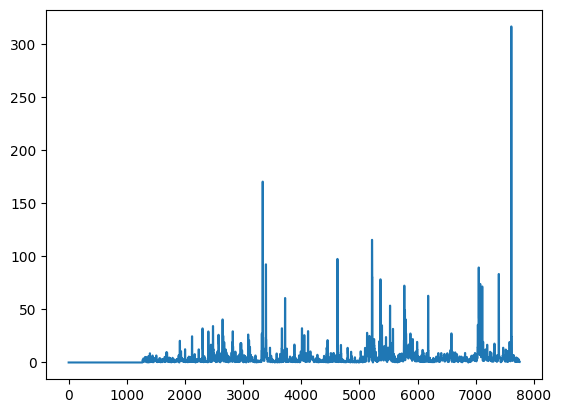

In [10]:
# Plotting and calculating the maximum turbulence
%matplotlib inline
print(data[['turbulence']].max())
data['turbulence'].plot()

Splitting data into training and trading set, by using the FinRL built in *data_split* function:

In [11]:
TRAIN_START_DATE = "2021-01-01"
TRAIN_END_DATE = "2024-03-01"
TRADE_START_DATE = "2024-05-05"
TRADE_END_DATE = "2025-03-15"

#Creating train and trade datasets
train_data = data_split(data, TRAIN_START_DATE,TRAIN_END_DATE)
trade_data = data_split(data, TRADE_START_DATE,TRADE_END_DATE)

# Environment

The trading task is inherently stochastic and is modeled as a Markov Decision Process (MDP), aiming to maximize returns over time. An agent learns through interactions with the market—observing states, executing actions, and receiving rewards that guide policy updates.

By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

**Action space:** The action space defines all the possible actions an agent can take at each time step. In a multi-asset portfolio, this involves choosing how to allocate capital across several cryptocurrencies. coin).

Multi-asset portfolio uses a buy/sell signals translated into position weights for every coin. Each element corresponds to an allocation weight or action (e.g., proportion of capital allocated to each coin). For example, "Buy 10 coins of ETC" or "Sell 10 coins of ETC" are 10 or -10, respectively. The agent outputs a vector of real numbers, normalized to a range of [-1, 1], because the policy for the A2C, and PPO agents is defined as a Gaussian distribution.

**Reward function:** The reward function guides the agent toward maximizing some measure of portfolio performance. In trading, the reward is used to incentivize profitable trades, penalize risk or volatility, and reflect realistic trading constraints (e.g., slippage, transaction costs). The reward is calculated as a change of the portfolio value when action $a$ is taken at state $s$, and arriving at new state $s'$, by the following  $r(s, a, s′) = v′ − v$, where $v′$ and $v$ represent the portfolio values at state $s'$ and $s$, respectively. Reward is then scaled by reward_scale = 1e-4, but tested also with scaling of self.reward_scale = 1e-12, and reward_scale = 1e-8. Best results are obtained with the 1e-4 scaling, in combination with hyperparameters.

**State space:** In a DRL trading environment, the state space defines the information available to the agent at each time step to make trading decisions. It is essentially an observation or an input vector that the neural networks (actor and critic) consume to determine the best action. The state space of this problem contains 51 dimensions, including:
- Available balance at the every timestep
- Current prices of 5 crypto assets
- 8 indicators listed abowe
- Current Action Space, which is a 5-dimensional continuous action space, each one represents the number of each asset to be purchased or to be sold.

**Market environment data:** OHLCV data for 5 cryptocurrencies, plus 8 indicators

**Trading frequency:** Daily


In [12]:
asset_dimension = len(data['tic'].unique())
state_space = 1 + 2*asset_dimension + len(INDICATORS)*asset_dimension
print(f"Asset Dimension: {asset_dimension}, State Space: {state_space}")


Asset Dimension: 5, State Space: 51


## Environment setup

In [13]:
buy_cost_list = sell_cost_list = [0] * asset_dimension
num_stock_shares = [0] * asset_dimension

env_kwargs = {
    "hmax": 100, #maximum number of coins to trade
    "initial_amount": 1000000, #initial capital
    "num_stock_shares": num_stock_shares, #number of assets
    "buy_cost_pct": buy_cost_list, #transaction cost percentage per trade, not used for the sake od simplicity
    "sell_cost_pct": buy_cost_list,
    "state_space": state_space,
    "stock_dim": asset_dimension,
    "tech_indicator_list": INDICATORS, #list of techinal indicators
    "action_space": asset_dimension,
    "reward_scaling": 1e-4, #scaling factor for reward, good for training
    "print_verbosity":5

}

e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [14]:
env_train, _ = e_train_gym.get_sb_env()
e_trade_gym = StockTradingEnv(df = trade_data, turbulence_threshold = 700, **env_kwargs)

# DRL Algorithms

Parallel testing of the Ensemble strategy combining A2C, PPO, and DDPG agents, and A2C, PPO, and TD3 agents, resulted with the TD3 agent performing superior, as a standalone model, and DDPG usually having the worst standalone performance. However, during the simulations of the Ensemble strategy, using the TD3 algorithm instead of the DDPG model, did not improve performance of the Ensemble strategy. In some cases, when the TD3 model is used the Ensemble strategy used mostly the A2C and PPO models, which showed that it is better to use the DDPG algorithm. In a different timeframes for learning and trading the PPO model significantly overperformed all other strategies, almost perfectly foolowing trends. However, it showed that the dataset also impacts the models performances, and therefore the Ensemble strategy.

Therefore, the Ensemble strategy is a good strategy to combine the three models utilising the best properties of each DRL algorithm. As the strategy is combining A2C, PPO, and DDPG with the goal of selecting the best-performing agent each quarter based on Sharpe ratio, as part of an ensemble trading strategy. Given that ensemble stability and adaptability are more important than individual agent performance, the accent was on setting up the parameters to achieve a complementary behavior across the agents and a robust regime coverage, above the isolated agent success.

The A2C, PPO, and DDPG agents all implement the fundamental RL loop of interacting with an environment, receiving rewards, and learning from the experience, while using different strategies for balancing learning stability, sample efficiency, and action flexibility.
The A2C and the PPO agents use the stochastic policies and an advantage estimation, while the DDPG agent uses the deterministic policies. Each DRL algorithm has a distinct mechanism for updating its value function and policy, with the PPO emphasizing the stable updates, but all three agents rely on the environment to provide rewards and feedback that drive learning.

## Setting the hyperparameters for training and trading

During the testing of the project, the biggest challege was setting up the optimal hyperparameters for the DRL models, as their performance is heavily dependant on them, and required a lot of tuning, which is not straightforward. Also, there is a difference between the DRL model in learning efficiences, policy updates, etc. For example, DDPG is a Q- learning based “off-policy” method and learns from past samples using the experience replay buffers.
Furthermore, the unpredictable behaviour of the DRL models using the same data and same hyperparameters, made them sometimes overperform the ensemble strategy, but in other cases with the same setting (same parameters and environment) have suboptimal outcome. In the case of the A2C algorithm this is, most likely, because of the liability of the A2C algorithm toward overfitting, which would make it a bad choice to use alone in the real-world trading.

During the testing and trading there are two core behaviors a DRL agent must constantly balance well, as it is crucial for learning effective trading policies, especially in complex, noisy environments like crypto markets: exploration and exploitation.

During the exploration the agent tries new, or uncertain, actions to learn more about the environment, even if they may not immediately seem profitable, with the goal of finding the potentially better strategies or unexpected profitable actions.
During the exploitation it uses its current knowledge of profitable actions to choose the action it believes will yield the highest reward, with the goal to maximize rewards, based on what the agent has already learned.

**n_steps:**

n_steps is the number of timesteps the DRL agent collects before each update of the policy and value networks. The impact on trading depends on the DRL model. For example, higher values for the A2C model(e.g., 20-50) means that an agent collects more market information before updating, which leads to better stability, but slower agent reactions. Lower values (e.g., 5-10) leads to making the updates more frequently, quicker agent adaptation to the environment but risks increasing the variance in the learning process.

**Learning Rate (learning_rate):**

Learning rate is a parameter in DRL models that controls how much the model updates its weights during training. If the learning rate is too high the agent learns too quickly and faster adapts, but it can lead to unstable updates and erratic trading decisions. If the learning rate is too low the agent learns slowly but the learning is stable, with the risk that an agent misses profitable trades failing to adapt to new market conditions.

**Entropy Coefficient (ent_coef):**

Entrophy coefficient controls the level of exploration by adding randomness to actions.
High entropy coefficient encourages more exploration, which may be useful in unpredictable markets. However, while entropy is essential early on, high entropy may block the agent from shifting to a confident, profitable policy which may be a reason for the agents underperformance. Low entropy focuses on learned profitable trades.
In a noisy, fast-changing environment like crypto, too high entropy coeficient causes an agent to behave randomly, fail to converge, and miss profitable trading opportunities. This can also affect the Ensemble strategy because if the agents are too exploratory, none of them will dominate, which could make the agent selection unreliable. The DDPG agent doesn’t use entropy.

**Training Timesteps:**

Timesteps are the total number of iterations the DRL model trains. If number of timesteps is low the model doesn’t learn enough to make good trading decisions. This parameter has most impact on the A2C model, but also has a significant influence on the other two models. If the number of timesteps is too high there is a risk that the model will overfit to the historical market conditions.

**Batch Size (batch_size):**

Batch size refers to a number of the training samples used in one update of the model’s parameters.

**For future research:**

An optimal solution for hyperparameters setup would be the constant adaptation depending on the market conditions. This is out of the scope for this project, but for the real-world trading it would be something to work on before deploying the strategy to trade on the exchange. For example, adapting the learning rate by reducing it when the model stabilizes, and increasing when retraining in new markets. Another example would be to gradually reduce enthropy coefficient as the model becomes more confident in its strategy. Increasing the number of timesteps would also have a big impact on the performace of the agents.


In [15]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.001,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef": 0.001,
                    "n_steps": 2048,
                    "learning_rate": 0.0005,
                    "batch_size": 128
                    }


DDPG_model_kwargs = {
                     "buffer_size": 10000,
                     "learning_rate": 0.0005,
                     "batch_size": 128
                    }


timesteps_dict = {
                 'a2c': 1000,
                 'ppo': 1000,
                 'ddpg': 1000
                 }

###  The Advantage Actor-Critic (A2C) model

The Advantage Actor-Critic (A2C) algorithm is a widely used method within the family of policy-gradient reinforcement learning algorithms. The A2C model serves as a synchronous version of the older asynchronous variant known as the A3C (Asynchronous Advantage Actor-Critic) algorithm, and brings improvement in model stability by updating the parameters synchonously, after collecting a batch of experiences, rather than asynchronously.

The goal of the A2C model is to maximize the expected cumulative reward an agent can achieve over time through the interaction with the environment. To achieve this, the A2C model uses two neural networks (actor and critic) that separately address the policy optimization (via the actor), and the value estimation (via the critic), and collaborate with a goal of learning the optimal policy:

**Actor (Policy Network):** The actor network, in a time $t$, as an input has the current state $s_t$, and outputs an action $a_t$. The actor network learns the policy function $\pi(a \mid s)$, which maps the input state to a probability distribution over all possible actions. Based on these probabilities the actor chooses the action which is then applied to the environment, while the environment returns the next state $s_{t+1}$ and a reward.

**Critic (Value Network):** The critic network learns the value function $V(s_t)$ which estimates the expected rewards starting from a state $s$, under the current policy.

The Advantage function is calculated as a difference between the actual reward and the expected reward:
$$
 A(s_t, a_t) = r_t + \gamma V(s_{t+1}) - V(s_t)
$$

where $r_t$ is the immediate reward received after taking action $a_t$, $\gamma \in [0, 1]$ is the discount factor, a real number between 0 and 1, which determines the present value of future rewards. In cryprocyrrency tranding $\gamma$ is 0. The $V(s_{t+1})$ is the estimated value of the next state.

This advantage is used to update the policy by adjusting the actor’s parameters to increase the probability of advantageous actions.

In [16]:
agent = DRLAgent(env = env_train)

As per documentation, the DRLAgent class provides implementations for DRL algorithms:

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results


In [17]:
# The get_model function sets the DRL algorithm
model_a2c = agent.get_model("a2c", model_kwargs = A2C_model_kwargs)

# Set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])

# Set new logger
model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.001, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [18]:
# The train_model function takes the selected model, and trains it for n timesteps
trained_a2c = agent.train_model (model = model_a2c, tb_log_name = 'a2c', total_timesteps = timesteps_dict['a2c'])

------------------------------------
| time/                 |          |
|    fps                | 174      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -7.04    |
|    explained_variance | 0.0124   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -82.6    |
|    reward             | 7.106895 |
|    std                | 0.989    |
|    value_loss         | 183      |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 222        |
|    iterations         | 200        |
|    time_elapsed       | 4          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -7.02      |
|    explained_variance | -0.355     |
|    learning_rate      | 0.0007     |
|    n_updates    

In [19]:
# Getting the account value, and the actions DataFrames
df_account_value_a2c, df_a2c_actions = DRLAgent.DRL_prediction(model=trained_a2c, environment = e_trade_gym)
df_a2c_actions.to_csv('df_a2c_actions.csv')
print(df_account_value_a2c)
print(df_a2c_actions)

Done!
          date  account_value
0   2024-05-05   1.000000e+06
1   2024-05-06   1.002443e+06
2   2024-05-07   9.894071e+05
3   2024-05-08   9.768228e+05
4   2024-05-09   9.594783e+05
..         ...            ...
309 2025-03-10   1.241901e+06
310 2025-03-11   1.208680e+06
311 2025-03-12   1.275499e+06
312 2025-03-13   1.288856e+06
313 2025-03-14   1.248129e+06

[314 rows x 2 columns]
              ADA-USD  BTC-USD   DOGE-USD    ETH-USD    SOL-USD
date                                                           
2024-05-05  17.398361     15.0  25.759867  13.000000   7.000000
2024-05-06 -11.026966      0.0 -22.309368 -12.544015  11.499598
2024-05-07  -6.371395      0.0  -3.450499  -0.455985   9.839179
2024-05-08   0.000000      0.0   0.000000   0.000000   9.839179
2024-05-09   0.000000      0.0   0.000000   0.000000   9.839179
...               ...      ...        ...        ...        ...
2025-03-09   0.000000      0.0   0.000000   0.000000   0.000000
2025-03-10   0.000000      0.0   0

Tralalala, ponasanje A2C actions

In [20]:
# Create DataFrame with portfolio values in $
df_account_value_a2c = pd.DataFrame({'date': df_account_value_a2c['date'], 'account_value_a2c': df_account_value_a2c['account_value']})
df_account_value_a2c = df_account_value_a2c.set_index('date')
df_account_value_a2c

,account_value_a2c
date,
2024-05-05,1.000000e+06
2024-05-06,1.002443e+06
2024-05-07,9.894071e+05
2024-05-08,9.768228e+05
2024-05-09,9.594783e+05
...,...
2025-03-10,1.241901e+06
2025-03-11,1.208680e+06
2025-03-12,1.275499e+06


In [21]:
# Calculate daily returns
df_account_value_a2c['daily_return_a2c'] = df_account_value_a2c['account_value_a2c'].pct_change()

# Calculate cumluative returns
df_account_value_a2c['cumuluative_return_a2c'] = np.exp(np.log1p(df_account_value_a2c['daily_return_a2c']).cumsum())-1
df_account_value_a2c['cumuluative_return_a2c']

,cumuluative_return_a2c
date,
2024-05-05,NaN
2024-05-06,0.002443
2024-05-07,-0.010593
2024-05-08,-0.023177
2024-05-09,-0.040522
...,...
2025-03-10,0.241901
2025-03-11,0.208680
2025-03-12,0.275499


### The Proximal Policy Optimization (PPO) model

The Proximal Policy Optimization (PPO) model is, as well as the A2C model, from the policy-gradient reinforcement learning algorithms, and is based on the similar idea of updating the policy function but, in adittion, the PPO model, uses a clipping mechanism for updating the policy function, and ensures more stable learning compared to the A2C model. The motivation behind the clipping machanism is to optimize the objective function while ensuring the deviation from the previous policy is relatively small, which helps the PPO model to learn faster as it avoids overshooting and needing to relearn bad trades.

The PPO loss function is defined as:
$$
\text{Loss} = \min\left( r(\theta) A, \; \text{clip}(r(\theta), 1 - \epsilon, 1 + \epsilon) \cdot A \right)
$$
where $r(\theta) = \frac{\pi_{\theta}(a \mid s)}{\pi_{\text{old}}(a \mid s)} $,  $A$  is the advantage estimate, and $\epsilon$ is a small numeric value, for example  0.2.

In [22]:
# The get_model function sets the DRL algorithm
model_ppo = agent.get_model("ppo", model_kwargs = PPO_model_kwargs)
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'ent_coef': 0.001, 'n_steps': 2048, 'learning_rate': 0.0005, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [23]:
trained_ppo = agent.train_model(model = model_ppo, tb_log_name = 'ppo', total_timesteps = timesteps_dict['ppo'])

------------------------------------
| time/              |             |
|    fps             | 367         |
|    iterations      | 1           |
|    time_elapsed    | 5           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.23850761 |
------------------------------------


In [24]:
# Getting the account value, and the actions DataFrames
df_account_value_ppo, df_ppo_actions = DRLAgent.DRL_prediction(model = trained_ppo, environment = e_trade_gym)
print(df_account_value_ppo)
print(df_ppo_actions)

day: 313, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1045734.80
total_reward: 45734.80
total_cost: 0.00
total_trades: 1260
Sharpe: 0.299
Done!
          date  account_value
0   2024-05-05   1.000000e+06
1   2024-05-06   1.001046e+06
2   2024-05-07   9.892350e+05
3   2024-05-08   9.763300e+05
4   2024-05-09   9.585450e+05
..         ...            ...
309 2025-03-10   1.068824e+06
310 2025-03-11   1.022768e+06
311 2025-03-12   1.071599e+06
312 2025-03-13   1.077338e+06
313 2025-03-14   1.045735e+06

[314 rows x 2 columns]
             ADA-USD   BTC-USD  DOGE-USD   ETH-USD   SOL-USD
date                                                        
2024-05-05  0.000000  7.168417  0.771477  0.000000  0.000000
2024-05-06  0.000000  6.320907 -0.771477  0.000000  0.000000
2024-05-07  0.000000  2.000000  0.000000  0.832317  0.000000
2024-05-08  8.268611  0.000000  0.000000  2.000000  2.285413
2024-05-09  8.268611  0.000000  0.000000  0.000000  2.285413
...              ...       ... 

The action DataFrame for the PPO model implies tha the PPO model has the most dynamic, and therefore riskier, trading style than the A2C, and the DDPG model which is the most conservative.

In [25]:
# Create DataFrame with portfolio values in $
df_account_value_ppo = pd.DataFrame({'date': df_account_value_ppo['date'],'account_value_ppo': df_account_value_ppo['account_value']})
df_account_value_ppo = df_account_value_ppo.set_index('date')
df_account_value_ppo

,account_value_ppo
date,
2024-05-05,1.000000e+06
2024-05-06,1.001046e+06
2024-05-07,9.892350e+05
2024-05-08,9.763300e+05
2024-05-09,9.585450e+05
...,...
2025-03-10,1.068824e+06
2025-03-11,1.022768e+06
2025-03-12,1.071599e+06


In [26]:
# Calculate daily returns
df_account_value_ppo['daily_return_ppo'] = df_account_value_ppo['account_value_ppo'].pct_change()

# Calculate cumluative returns
df_account_value_ppo['cumuluative_return_ppo'] = np.exp(np.log1p(df_account_value_ppo['daily_return_ppo']).cumsum())-1
df_account_value_ppo['cumuluative_return_ppo']

,cumuluative_return_ppo
date,
2024-05-05,NaN
2024-05-06,0.001046
2024-05-07,-0.010765
2024-05-08,-0.023670
2024-05-09,-0.041455
...,...
2025-03-10,0.068824
2025-03-11,0.022768
2025-03-12,0.071599


## The Deep Deterministic Policy Gradient (DDPG) model

The DDPG model is an off-policy, actor-critic, algorithm specifically designed for environments with continuous action spaces. The DDPG model combines the strengths of Deep Q-Networks (DQN) and Deterministic Policy Gradient (DPG) to learn efficient policies in high-dimensional, continuous domains, such as algorithmic trading or robotic control.

The Actor learns a deterministic policy $\mu(s \mid \theta^\mu)$ , that maps a state $s$ directly to a specific action $a$.
The Critic approximates the $Q$-function $Q(s, a \mid \theta^Q)$, which estimates the expected cumulative reward for taking an action $a$ in a state $s$, following the current policy. Unlike the stochastic on-policy methods like A2C and PPO, the DDPG model uses a deterministic policy.

The DDPG model has the following key elements:

A Replay Buffer is a memory buffer that stores the touple of transitions ($s_t$, $a_t$, $r_t$, and $s_t+1$) which are randomly sampled during training. This breaks a correlation between the consecutive samples and stabilizes learning.
The Target Networks in the DDPG model maintain the delayed copies of the actor and critic networks, denoted $\mu$, $\mu'$ and $Q$, $Q'$.

Since the DDPG policy is deterministic, the model introduces an exploration noise, often using the Ornstein–Uhlenbeck (OU) process or an Gaussian noise, added to the actor’s output during training:
$$
a_t = \mu(s_t \mid \theta^\mu) + \mathcal{N}_t
$$
This method encourages exploration of the state-action space, which is critical in a sparse or noisy reward environments like cryptocurrency trading.

In [27]:
# The get_model function sets the DRL algorithm
model_ddpg = agent.get_model("ddpg", model_kwargs = DDPG_model_kwargs)

tmp_path = RESULTS_DIR + '/ddpg'
new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 128}
Using cuda device
Logging to results/ddpg


In [28]:
trained_ddpg = agent.train_model(model = model_ddpg, tb_log_name = 'ddpg', total_timesteps = timesteps_dict['ddpg'])

In [29]:
# Getting the account value, and the actions DataFrames
df_account_value_ddpg, df_ddpg_actions = DRLAgent.DRL_prediction(model = trained_ddpg, environment = e_trade_gym)
print(df_account_value_ddpg)
print(df_ddpg_actions)

Done!
          date  account_value
0   2024-05-05   1.000000e+06
1   2024-05-06   1.001945e+06
2   2024-05-07   9.884114e+05
3   2024-05-08   9.700771e+05
4   2024-05-09   9.579707e+05
..         ...            ...
309 2025-03-10   6.618418e+05
310 2025-03-11   6.114079e+05
311 2025-03-12   6.324260e+05
312 2025-03-13   6.297687e+05
313 2025-03-14   6.144834e+05

[314 rows x 2 columns]
            ADA-USD  BTC-USD  DOGE-USD  ETH-USD  SOL-USD
date                                                    
2024-05-05      0.0      0.0     100.0    100.0    100.0
2024-05-06      0.0      0.0     100.0    100.0    100.0
2024-05-07      0.0      0.0     100.0    100.0    100.0
2024-05-08      0.0      0.0     100.0      2.0    100.0
2024-05-09      0.0      0.0      70.0      0.0     20.0
...             ...      ...       ...      ...      ...
2025-03-09      0.0      0.0       0.0      0.0      0.0
2025-03-10      0.0      0.0       0.0      0.0      0.0
2025-03-11      0.0      0.0       0.0  

The actions DataFrame shows that the DDPG model tends to buy a certain amount of assets, and hold them until the end of the trade. The same behaviour has noted when the TD3 model is tested, which imposes the conclusion that this is a common behaviour for these models, probably related to their embedded risk management, and the learning process.

In [30]:
# Create DataFrame with portfolio values in $
df_account_value_ddpg = pd.DataFrame({'date': df_account_value_ddpg['date'], 'account_value_ddpg': df_account_value_ddpg['account_value']})
df_account_value_ddpg = df_account_value_ddpg.set_index('date')
df_account_value_ddpg

,account_value_ddpg
date,
2024-05-05,1.000000e+06
2024-05-06,1.001945e+06
2024-05-07,9.884114e+05
2024-05-08,9.700771e+05
2024-05-09,9.579707e+05
...,...
2025-03-10,6.618418e+05
2025-03-11,6.114079e+05
2025-03-12,6.324260e+05


In [31]:
# Calculate daily returns
df_account_value_ddpg['daily_return_ddpg'] = df_account_value_ddpg['account_value_ddpg'].pct_change()

# Calculate cumluative returns
df_account_value_ddpg['cumuluative_return_ddpg'] = np.exp(np.log1p(df_account_value_ddpg['daily_return_ddpg']).cumsum())-1
df_account_value_ddpg['cumuluative_return_ddpg']

,cumuluative_return_ddpg
date,
2024-05-05,NaN
2024-05-06,0.001945
2024-05-07,-0.011589
2024-05-08,-0.029923
2024-05-09,-0.042029
...,...
2025-03-10,-0.338158
2025-03-11,-0.388592
2025-03-12,-0.367574


## The Ensemble Strategy

In [32]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

TRAIN_START_DATE = "2021-01-01"
TRAIN_END_DATE = "2024-03-01"
TEST_START_DATE = "2024-03-02"
TEST_END_DATE = "2025-12-31"

ensemble_agent = DRLEnsembleAgent(df=data,
                                  train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                                  val_test_period=(TEST_START_DATE,TEST_END_DATE),
                                  rebalance_window=rebalance_window,
                                  validation_window=validation_window,
                                  **env_kwargs)



In [33]:
summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                               PPO_model_kwargs,
                                               DDPG_model_kwargs,
                                               timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  34.306777104598716
======Model training from:  2021-01-01 to  2024-03-03 00:00:00
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.001, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
------------------------------------
| time/                 |          |
|    fps                | 304      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -7.08    |
|    explained_variance | 0.0363   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -130     |
|    reward             | 1.426098 |
|    std                | 0.997    |
|    value_loss         | 636      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 301     

In [34]:
summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2024-03-03 00:00:00,2024-05-05 00:00:00,A2C,0.098536,0.015673,0.057199
1,189,2024-05-05 00:00:00,2024-07-07 00:00:00,A2C,0.02808,-0.083389,-0.034014
2,252,2024-07-07 00:00:00,2024-09-08 00:00:00,PPO,-0.245023,-0.107543,-0.21629
3,315,2024-09-08 00:00:00,2024-11-10 00:00:00,A2C,0.612424,0.539118,0.512623
4,378,2024-11-10 00:00:00,2025-01-12 00:00:00,PPO,0.158706,0.177983,-0.164796


# The Ensemble Strategy Backtest
To evaluate the performance of a trading strategy we use backtesting. There are automated backtesting tools, such as the Quantopian pyfolio package, and usually the automated testing is preferred because it reduces the posibillity of a human error. They are also easier to use, and contain various individual plots that provide a comprehensive image of the performance of a trading strategy. In this project backtesting was done 'manually' as the results were used for comparison with the other strategies.
First, we will set the dates to use for backtesting a strategy on the trading period:

In [35]:
unique_trade_date = data[(data['date'] > TEST_START_DATE)&(data['date'] <= TEST_END_DATE)]['date'].unique()

In [36]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

# Calculating the out-of-sample results
df_account_value_ensemble = pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1, rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble', i))
    df_account_value_ensemble = pd.concat([df_account_value_ensemble, temp], ignore_index=True)

df_account_value_ensemble = df_account_value_ensemble.join(df_trade_date[validation_window:].reset_index(drop=True))
df_account_value_ensemble

,account_value,date,daily_return,datadate
0,1.000000e+06,2024-05-05,NaN,2024-05-05
1,1.002187e+06,2024-05-06,0.002187,2024-05-06
2,9.975810e+05,2024-05-07,-0.004596,2024-05-07
3,9.829384e+05,2024-05-08,-0.014678,2024-05-08
4,9.770498e+05,2024-05-09,-0.005991,2024-05-09
...,...,...,...,...
310,8.527521e+05,2025-03-11,-0.023762,2025-03-11
311,8.983559e+05,2025-03-12,0.053478,2025-03-12
312,9.070384e+05,2025-03-13,0.009665,2025-03-13
313,8.787854e+05,2025-03-14,-0.031149,2025-03-14


In [37]:
# Create DataFrame with results from the Ensemble strategy

df_account_value_ensemble = pd.DataFrame({'date': df_account_value_ensemble['date'], 'account_value_ensemble': df_account_value_ensemble['account_value']})
df_account_value_ensemble = df_account_value_ensemble.set_index('date')
df_account_value_ensemble.to_csv("ensemble_result.csv")

In [38]:
# Calculate daily returns
df_account_value_ensemble['daily_return_ensemble'] = df_account_value_ensemble['account_value_ensemble'].pct_change()

# Calculate cumluative returns
df_account_value_ensemble['cumuluative_return_ensemble'] = np.exp(np.log1p(df_account_value_ensemble['daily_return_ensemble']).cumsum())-1

Parallel testing of strategies, with DDPG and TD3, resulted with TD3 perform much better as a standalone model, and DDPG usually having the worst standalone performance. However, in the Ensemble strategy, TD3 was rarely chosen into the ensemble trading strategy for the next quarter, resulting with lower performance of the Ensemble strategy, than using the DDPG model, because it used mostly A2C and PPO models, which showed us that more agents should be included. Furthermore, the unpredictable behaviour of standalone models using the same data and same hyperparameters, made them sometimes overperform the ensemble strategy, but in other cases with the same setting (same parameters and environment) have suboptimal outcome. In the case of the A2C algorithm, this is probably because of the liability of the A2C algorithm toward overfitting, which would make it a bad choice to use alone in the real-world crypto trading. Therefore, the Ensemble strategy is a good strategy to combine the three models utilising the best properties of each DRL algorithm.

## Minimum Variance Optimisation

The Minimum Variance Portfolio is the portfolio of assets that has the lowest possible variance (risk) for a given set of assets, without necessarily considering expected returns. This approach is purely focused on minimizing portfolio volatility, making it useful in risk-sensitive strategies or as a benchmark for comparison.

Train data is adjusted based on the step in the ensemble algorithm validation.
The objective of the minimum variance optimization is to find the portfolio weights $\mathbf{w} \in \mathbb{R}^n$ that minimize the portfolio variance:
$$
\sigma_p^2 = \mathbf{w}^\top \Sigma \mathbf{w}
$$

Subject to:
$$
\mathbf{1}^\top \mathbf{w} = 1
$$
$$
-1 \leq w_i \leq 1 \quad \forall i
$$

Where $\Sigma$ is the covariance matrix of asset returns, $\mathbf{w}$ is the weight vector, $\mathbf{1}$ is a vector of ones.

This formulation allows for long/short positions, but doesn't limit the size of any position to 100% of the portfolio value, to prevent excessive leverage. As explained below, this hapenned in the case of Bitcoin in the portfolio, so in code, different constraints are used.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Dates module for x-axis formatting
import cvxpy as cp

In [40]:
data = pd.read_csv('data.csv',parse_dates=['date'], index_col='date')
data = data.sort_values(['date', 'tic'])
data = data.pivot(columns='tic', values='close')
data

tic,ADA-USD,BTC-USD,DOGE-USD,ETH-USD,SOL-USD
date,,,,,
2021-01-01,0.181382,28994.009766,0.004681,737.708374,1.509775
2021-01-02,0.175359,29376.455078,0.005686,730.402649,1.845586
2021-01-03,0.177382,32129.408203,0.010602,774.511841,1.799902
2021-01-04,0.205236,32810.949219,0.009785,977.058838,2.162412
2021-01-05,0.224817,31977.041016,0.009767,1041.498779,2.490982
...,...,...,...,...,...
2025-03-27,0.728077,86896.257812,0.194798,2008.940552,137.290955
2025-03-28,0.737673,87185.234375,0.190495,2002.410522,138.347244
2025-03-29,0.705549,84352.070312,0.180191,1895.549683,129.424515


In [41]:
# Splitting the data into the training and trading periods
train_start = '2021-01-01'
train_end = '2024-03-01'
trade_start = '2024-05-05'
trade_end = '2025-03-15'


# Creating the train and trade datasets
train = data[train_start:train_end]
trade = data[trade_start:trade_end]

# Calculating the covariance matrix from the training data returns
returns = train.pct_change().dropna()
cov_matrix = returns.cov()
cov_matrix

tic,ADA-USD,BTC-USD,DOGE-USD,ETH-USD,SOL-USD
tic,,,,,
ADA-USD,0.002703,0.001133,0.002077,0.001532,0.001846
BTC-USD,0.001133,0.001128,0.001671,0.001185,0.001250
DOGE-USD,0.002077,0.001671,0.026114,0.001842,0.001805
ETH-USD,0.001532,0.001185,0.001842,0.001893,0.001789
SOL-USD,0.001846,0.001250,0.001805,0.001789,0.004545


The covariance matrix $\Sigma \in \mathbb{R}^{n \times n}$ captures how pairs of asset returns move together. Each element $\Sigma_{ij}$ is defined as:

$$
\Sigma_{ij} = \text{Cov}(R_i, R_j)
$$

where the diagonal entries $\Sigma_{ii}$ represent the **variance** of asset $i$. The off-diagonal entries $\Sigma_{ij}$ for $i \neq j$ represent the **covariance** (co-movement) between asset $i$ and asset $j$.

In [42]:
# Implementing the Minimum Variance Portfolio Optimization

n = len(cov_matrix)
weights = cp.Variable(n)
portfolio_variance = cp.quad_form(weights, cov_matrix)

# Setting the optimization constraints

constraints = [cp.sum(weights) == 1, weights >= -1, weights <= 0.2]
problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)
problem.solve()

# Get the optimized weights

optimal_weights = weights.value
optimal_weights

array([0.19999995, 0.20000025, 0.19999999, 0.20000005, 0.19999976])

Initially the optimization constraints for weights were the following: weights sum is equal to 1 as the minimum variance problem requires, and can be between -1 and 1, to allow short selling.
Howewer, the results with the weights constraints [-1, 1], were in this case giving the following weights: [ 0.059111    1.  -0.01838817 -0.03523041 -0.00549243] using cvxpy, and the [ 0.06061209  1. -0.01816012 -0.03685465 -0.00559731] when using the same constraing and the scipy minimize method. To prevent the optimizer from allocating 100% to BTC, and ensure the diversity of the portfolio, the weights constraints [-1, 0.2] are used.

In [43]:
# Calculate account value during the trading period
initial_portfolio_value = 1000000

# Get latest prices (most recent row of price DataFrame)
last_prices = train.tail(1).to_numpy().flatten()
min_weights = initial_portfolio_value * optimal_weights

# Convert dollar allocation to number of shares
initial_portfolio = min_weights / last_prices

# Multiply asset quantities by daily prices to get portfolio value over time
account_value_min_variance = trade @ initial_portfolio

# Store the results in a DataFrame
df_account_value_min_variance = pd.DataFrame(account_value_min_variance, columns=["account_value_min_variance"])

In [44]:
# Calculate daily returns
portfolio_returns = account_value_min_variance.pct_change().dropna()

# Calculate cumluative returns
cumulative_returns = np.exp(np.log1p(portfolio_returns).cumsum())-1

In [45]:
# Create DataFrame with results from the Minimum Variance strategy
df_account_value_min_variance = pd.DataFrame({'account_value_min_variance': account_value_min_variance, 'cumuluative_return_min_variance': cumulative_returns}, index=trade.index)
df_account_value_min_variance['cumuluative_return_min_variance'] = cumulative_returns
df_account_value_min_variance

,account_value_min_variance,cumuluative_return_min_variance
date,,
2024-05-05,1.042951e+06,NaN
2024-05-06,1.043896e+06,0.000906
2024-05-07,1.039009e+06,-0.003780
2024-05-08,1.010736e+06,-0.030889
2024-05-09,9.872598e+05,-0.053398
...,...,...
2025-03-11,1.024560e+06,-0.017634
2025-03-12,1.085913e+06,0.041192
2025-03-13,1.108166e+06,0.062529


## Creating data for performance comparison

In [46]:
df_account_value_ensemble = df_account_value_ensemble.set_index(trade.index)
data_frames = [df_account_value_ensemble, df_account_value_min_variance, df_account_value_a2c, df_account_value_ppo, df_account_value_ddpg]
df_results = pd.concat(data_frames, axis=1)

For creating perfomance analytics the empyrical library, from Quantopian, is used:

In [47]:
cum_returns_min_var = round(cum_returns(portfolio_returns)*100, 2)
sharpe_ratio_min_var = round(sharpe_ratio(portfolio_returns, risk_free=0, period='daily'), 2)
max_drawdawn_min_var = round(max_drawdown(portfolio_returns)*100, 2)
annual_return_min_var = round(annual_return(portfolio_returns, period='daily')*100, 2)
annual_volatility_min_var = round(annual_volatility(portfolio_returns, period='daily')*100, 2)

In [48]:
cum_returns_ddpg = round(cum_returns(df_results['daily_return_ddpg'])*100, 2)
sharpe_ratio_ddpg = round(sharpe_ratio(df_results['daily_return_ddpg'], risk_free=0, period='daily'), 2)
max_drawdawn_ddpg = round(max_drawdown(df_results['daily_return_ddpg'])*100, 2)
annual_return_ddpg = round(annual_return(df_results['daily_return_ddpg'], period='daily')*100, 2)
annual_volatility_ddpg = round(annual_volatility(df_results['daily_return_ddpg'], period='daily')*100, 2)

In [49]:
cum_returns_a2c = round(cum_returns(df_results['daily_return_a2c'])*100, 2)
sharpe_ratio_a2c = round(sharpe_ratio(df_results['daily_return_a2c'], risk_free=0, period='daily'), 2)
max_drawdawn_a2c = round(max_drawdown(df_results['daily_return_a2c'])*100, 2)
annual_return_a2c = round(annual_return(df_results['daily_return_a2c'], period='daily')*100, 2)
annual_volatility_a2c = round(annual_volatility(df_results['daily_return_a2c'], period='daily')*100, 2)

In [50]:
cum_returns_ppo = round(cum_returns(df_results['daily_return_ppo'])*100, 2)
sharpe_ratio_ppo = round(sharpe_ratio(df_results['daily_return_ppo'], risk_free=0, period='daily'), 2)
max_drawdawn_ppo = round(max_drawdown(df_results['daily_return_ppo'])*100, 2)
annual_return_ppo = round(annual_return(df_results['daily_return_ppo'], period='daily')*100, 2)
annual_volatility_ppo = round(annual_volatility(df_results['daily_return_ppo'], period='daily')*100, 2)

In [51]:
cum_returns_ensemble = round(cum_returns(df_results['daily_return_ensemble'])*100, 2)
sharpe_ratio_ensemble = round(sharpe_ratio(df_results['daily_return_ensemble'], risk_free=0, period='daily'), 2)
max_drawdawn_ensemble = round(max_drawdown(df_results['daily_return_ensemble'])*100, 2)
annual_return_ensemble = round(annual_return(df_results['daily_return_ensemble'], period='daily')*100, 2)
annual_volatility_ensemble = round(annual_volatility(df_results['daily_return_ensemble'], period='daily')*100, 2)

## Plotting the final results

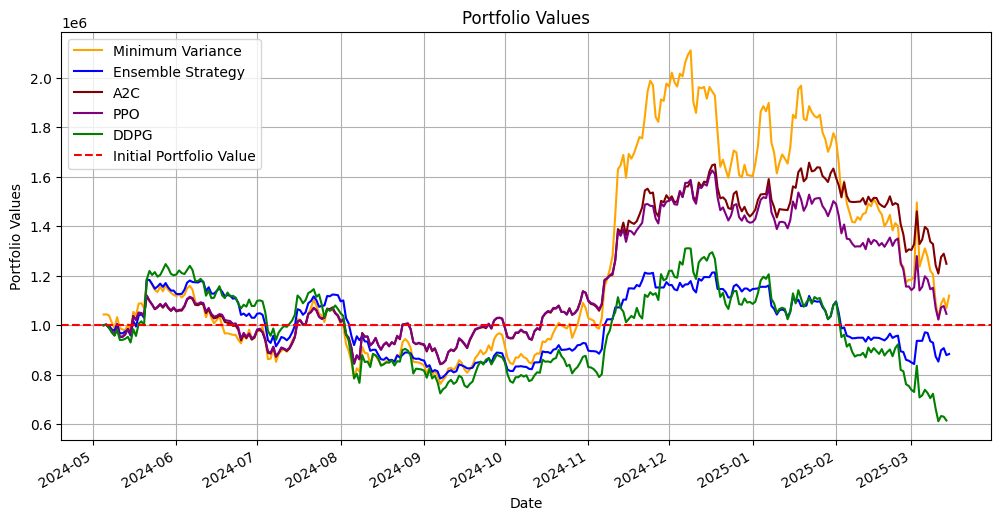

In [52]:
#Plotting the comparison of the portfolio values in the dollar value
plt.figure(figsize=(12, 6))

plt.plot(df_results.index, df_results['account_value_min_variance'], label='Minimum Variance', color='orange')
plt.plot(df_results.index, df_results['account_value_ensemble'], label='Ensemble Strategy', color='blue')
plt.plot(df_results.index, df_results['account_value_a2c'], label='A2C', color='maroon')
plt.plot(df_results.index, df_results['account_value_ppo'], label='PPO', color='purple')
plt.plot(df_results.index, df_results['account_value_ddpg'], label='DDPG', color='green')

# Setting the title and labels
plt.title('Portfolio Values')
plt.xlabel('Date')
plt.ylabel('Portfolio Values')
plt.axhline(y=initial_portfolio_value, color='r', linestyle='--', label='Initial Portfolio Value')

# Formatting the x-axis to show months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date display

# Rotating the date labels
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid()
plt.show()

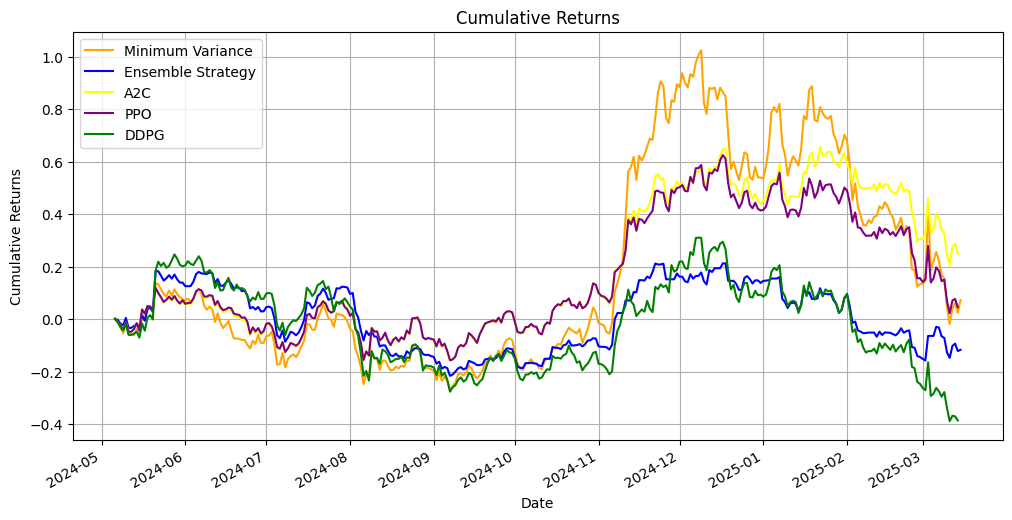

In [53]:
# Plotting the comparison of cumulative returns
plt.figure(figsize=(12, 6))

plt.plot(df_results.index, df_results['cumuluative_return_min_variance'], label='Minimum Variance', color='orange')
plt.plot(df_results.index, df_results['cumuluative_return_ensemble'], label='Ensemble Strategy', color='blue')
plt.plot(df_results.index, df_results['cumuluative_return_a2c'], label='A2C', color='yellow')
plt.plot(df_results.index, df_results['cumuluative_return_ppo'], label='PPO', color='purple')
plt.plot(df_results.index, df_results['cumuluative_return_ddpg'], label='DDPG', color='green')

# Set the title and labels
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
#plt.axhline(y=initial_portfolio_value, color='r', linestyle='--', label='Initial Portfolio Value')

# Formatting the x-axis to show months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date display

# Rotate date labels
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid()
plt.show()

Parallel testing of strategies, with DDPG and TD3, resulted with TD3 perform much better as a standalone model, and DDPG usually having the worst standalone performance. However, in the Ensemble strategy, when the TD3 model was used the Ensemble strategy had the lower performance, than when using the DDPG model.

Furthermore, the unstable behaviour of standalone models (specifically A2C and DDPG, where PPO showed to be the most stable) using the same data and same hyperparameters, made them sometimes overperform the Ensemble strategy, but in other cases with the same setting (same parameters and environment) have suboptimal outcome.

The number of timesteps for agents is one the parameters that has the biggest influence on how the agents behave and perform.
Also, all models and strategies have low performance when prices are declining, which can be seen on a plot in April 2025., when all five cryptocurrencies had a significant price drop. Similarily, in December 2024., all five cryptocurrencies had a significant surge in prices which reflected on the agents and strategies performance.

The most capable in following trends and volatile market, even with the small number of timesteps (tested on 5000 timesteps) is the PPO model, where it outperformed all other strategies, as it can explore early, and then exploit policies with clipped updates.

The A2C model shows fastest reactions to price changes, but doesn't have a good performance in a bear market, thereforet it would be a good choice in a flat market, or a stable or sideways markets. This behaviour is probably because of the liability of the A2C algorithm toward overfitting, which would make it a bad choice to use alone in the real-world crypto trading.

The worst performance was shown by the DDPG agent, because of its buy/hold early strategy where its performance deprecates when the prices are in down.

Good performance of a single agent does not guarantee the best performance of the Ensemble strategy. Therefore, the Ensemble strategy is a good strategy to combine the three models utilising the best properties of each DRL algorithm.

## Comparison of the performance metrics in %

### Sharpe Ratio

The Sharpe Ratio is one of the most widely used metrics for evaluating the risk-adjusted return of an investment or trading strategy, including crypto portfolios. It helps investors understand how much excess return they are receiving for the extra volatility they endure from holding a riskier asset. The Sharpe Ratio quantifies how well a portfolio compensates for volatility. In crypto, where volatility is extreme, a good Sharpe ratio is harder to achieve but more meaningful than just a raw return.

The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

where $R_p$ is the portfolio return, $R_f$ is the risk-free rate, and $\sigma_p$  is the standard deviation of portfolio returns.
A higher Sharpe ratio indicates better risk-adjusted performance, while a negative Sharpe ratio means that taking the risk but not being compensated.

### Cumulative Return

The Cumulative Return measures the total return of an investment over a period of time, taking into account compounding. It is calculated using the product of daily returns.
The cumulative return is defined as:
$$
\text{Cumulative Return} = \prod_{t=1}^{T} (1 + R_t) - 1
$$
where $R_t$ is the return at time $t$, and $T$ is the total number of time periods.

For example, a portfolio had the following daily returns over 3 days:
Day 1: +2% (0.02), Day 2: -1% (-0.01), Day 3: +1.5% (0.015)

Then:
$$
\text{Cumulative Return} = (1+0.02)(1−0.01)(1+0.015) − 1 =1.02×0.99×1.015 − 1 \approx 0.0241
$$
### Annual Return

Annual Return, also referred to as Annualized Return, is a standardized metric that expresses the rate of return of an investment on a yearly basis, regardless of the actual time frame of the investment. It represents the geometric average of returns achieved over a given period, scaled to one year. This metric is particularly useful in financial performance analysis, as it allows investors, analysts, and researchers to compare the profitability of assets or strategies that span different time durations.

For example, if one crypto trading strategy generates a 30% return over 18 months, and another yields a 25% return over 12 months, their raw returns are not directly comparable. Annualizing both returns provides a common temporal basis to assess which strategy has been more effective per unit time.

The annualized return incorporates the effect of compounding, making it a more accurate reflection of investment growth than simply dividing the total return by the number of years. It is a critical performance indicator in evaluating long-term trading strategies, portfolio management, and financial models like reinforcement learning agents in algorithmic trading.

The annual return is defined as:  
$$
\text{Annual Return} = (1 + R_{\text{total}})^{\frac{1}{n}} - 1
$$  
where $R_{\text{total}}$ is the cumulative return over the full period, and $n$ is the number of years.

For example, if a portfolio achieves a cumulative return of 25% over 1.5 years, the annualized return is  
$$
\text{Annual Return} = (1 + 0.25)^{\frac{1}{1.5}} - 1 \approx 0.157
$$.

### Annual Volatility

The Annual Volatility is a measure of the degree of variation in daily (or other period) returns of an asset or a portfolio, scaled to a one-year time frame. It reflects how much the returns fluctuate around the mean, and is often used as a proxy for risk. In the context of crypto, which is highly volatile, annualized volatility gives a meaningful way to assess and compare the riskiness of different coins or strategies.

Annual volatility is defined as:  
$$
\text{Annual Volatility} = \sigma_d \times \sqrt{N}
$$  
where $\sigma_d$ is the standard deviation of daily returns, and $N$ is the number of trading days in a year (usually $N = 252$).

### Maximum Drawdown

A Maximum Drawdown (MDD) is a risk metric that measures the largest peak-to-trough decline in a portfolio’s value over a specific time period. It shows the worst-case loss an investor might have experienced if they bought an asset at the peak price and sold at the lowest price.

A MMD is an important metric for financial trading and reinforcement learning in trading environments, because it reflects a downside risk, which is especially relevant in highly volatile markets like cryptocurrencies.

Maximum Drawdown (MDD) is defined as:

$$
\text{MDD} = \max_{t \in [0,T]} \left( \frac{\max_{\tau \in [0,t]} P_\tau - P_t}{\max_{\tau \in [0,t]} P_\tau} \right)
$$

where $P_t$ is the portfolio value at time $t$, and $\max_{\tau \in [0,t]}$ $P_\tau$  is the historical peak before or at time $t$.
The outer $max$ operator finds the worst (maximum) drawdown over the time interval $[0,T]$.

In [54]:
# Creating an empty DataFrame with columns and row names for
df_performance = pd.DataFrame(columns = ['Enseble', 'Min-Var', 'A2C', 'PPO', 'DDPG'],
                  index = ['Sharpe Ratio', 'Cumulative Return', 'Annual Return', 'Annual Volatility', 'Maximum Drawdown'])

# Adding rows to an empty dataframe at existing index
df_performance.loc['Sharpe Ratio'] = [sharpe_ratio_ensemble, sharpe_ratio_min_var, sharpe_ratio_a2c, sharpe_ratio_ppo, sharpe_ratio_ddpg]
df_performance.loc['Cumulative Return'] = [cum_returns_ensemble[-1], cum_returns_min_var[-1], cum_returns_a2c[-1], cum_returns_ppo[-1], cum_returns_ddpg[-1]]
df_performance.loc['Annual Return'] = [annual_return_ensemble, annual_return_min_var, annual_return_a2c, annual_return_ppo, annual_return_ddpg]
df_performance.loc['Annual Volatility'] = [annual_volatility_ensemble, annual_volatility_min_var, annual_volatility_a2c, annual_volatility_ppo, annual_volatility_ddpg]
df_performance.loc['Maximum Drawdown'] = [max_drawdawn_ensemble, max_drawdawn_min_var, max_drawdawn_a2c, max_drawdawn_ppo, max_drawdawn_ddpg]
df_performance

,Enseble,Min-Var,A2C,PPO,DDPG
Sharpe Ratio,-0.07,0.4,0.63,0.3,-0.39
Cumulative Return,-11.66,7.34,24.81,4.57,-38.55
Annual Return,-9.44,5.85,19.4,3.64,-32.27
Annual Volatility,38.14,62.75,42.67,43.68,57.64
Maximum Drawdown,-33.7,-51.48,-27.07,-37.08,-53.37


From the performance table we can see that the Ensemble strategy performed the best in all categories. As mentioned before, from the standalone DRL agents, the PPO showed the best performance in generating returns and following trends and performes the best in both bullish and bearish markets, with the lowest maximum drowdown, under these parameters.

The DDPG agent has a similar, but inferior performance as the PPO, and can be used a good addition to the Ensemble strategy, but not as a standalone agent as it performs worse than the Minimum Variance benchhmark.

The A2C in this simulation had the worst performance, but it changes in repetitive simulations, because of the instability of lerning. The A2C agent learns from the $n$ steps before every policy update, and drops the sample, taking a new sample in every timestep, meaning that the policy is fully based on the latest experience. This behaviour can lead to high-variance, unstable learning. The A2C agent may react excesive to short-term price changes. While A2C is a powerful reinforcement learning algorithm, it has several limitations when applied to financial trading. The A2C agent struggles to generalize across different market conditions, leading to poor performance when trends shift.

The PPO agent collects a big batch of data (e.g. 2048 steps), and splits it into mini-batches (e.g., 128 samples each), meaning that the PPO agent uses the same batch 16 times, which results in more efficient learning. This is called mini-batch stochastic gradient descent, and it helps the agent a better use of each experience, the model generalize rather than just memorize, and avoids throwing away good data after one update (unlike A2C).